# Predict mileage of cars, given values of following parameters for around 398 cars:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 
9. car name: string (unique for each instance)

https://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics


## Read data file

- '\s+' is a regex matching any whitespace character i.e. [\t\n\r\f\v]
- read *.data file using pandas.read_csv function by specificying the delimiter as space/tabe etc.

In [391]:
df = pd.read_csv('auto-mpg.data', sep='\s+', header=None, 
                 names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 
                        'modelyear', 'origin', 'carname'])

display(df.head(3))

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite


## Data Preprocessing

### Check for null, missing, incomplete, inappropriate values

In [392]:
df.isnull().sum()


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
modelyear       0
origin          0
carname         0
dtype: int64

In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
modelyear       398 non-null int64
origin          398 non-null int64
carname         398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


#### We see that horsepower column is percieved as object data type by Pandas, whereas we should be expecting a floating value. It means there is a string somewhere. Find that and deduce what to do.

##### 1. Display unique values in horsepower column

In [394]:
str(set(df['horsepower']))

"{'?', '160.0', '65.00', '129.0', '167.0', '66.00', '208.0', '103.0', '116.0', '60.00', '52.00', '92.00', '115.0', '139.0', '125.0', '70.00', '152.0', '97.00', '133.0', '210.0', '145.0', '90.00', '180.0', '63.00', '165.0', '84.00', '105.0', '158.0', '153.0', '95.00', '94.00', '77.00', '93.00', '72.00', '49.00', '48.00', '78.00', '71.00', '75.00', '148.0', '215.0', '76.00', '61.00', '108.0', '220.0', '46.00', '89.00', '80.00', '142.0', '200.0', '82.00', '54.00', '53.00', '102.0', '64.00', '86.00', '132.0', '79.00', '110.0', '138.0', '91.00', '112.0', '68.00', '130.0', '69.00', '100.0', '193.0', '85.00', '225.0', '87.00', '135.0', '96.00', '113.0', '83.00', '175.0', '140.0', '170.0', '137.0', '120.0', '107.0', '62.00', '198.0', '230.0', '67.00', '155.0', '88.00', '190.0', '149.0', '98.00', '150.0', '81.00', '122.0', '58.00', '74.00'}"

We can see that the only string present in the entire column is '?' in some rows. 
##### 2. Find percentage of non-numeric data in horsepower column

In [395]:
print('Percent of non-numeric data in horsepower  -->', len([x for x in df['horsepower'] if x == '?']) / len(df['horsepower']) * 100)

Percent of non-numeric data in horsepower  --> 1.507537688442211


##### 3. It turns out that only 1.5% of data is corrupt. So remove those rows

In [396]:
def removenotnum(list1):
    notnum = []
    for x in list1:
        try:
            float(x)
        except:
            notnum.append(x)
    return notnum

notnumtable = removenotnum(df['horsepower'])
print('all rubish values -->', set(notnumtable))
print('Percent of identified rubbish data in Table -->', len(notnumtable) / len(df['horsepower'])*100)

all rubish values --> {'?'}
Percent of identified rubbish data in Table --> 1.507537688442211


In [397]:
indexnames = df[(df['horsepower'] == '?')].index
indexnames
df.drop(axis=0,index=indexnames,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null object
weight          392 non-null float64
acceleration    392 non-null float64
modelyear       392 non-null int64
origin          392 non-null int64
carname         392 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 30.6+ KB


##### 4. Now convert the remaining cleane data to float

In [398]:
df['horsepower'] = df['horsepower'].astype(float)


In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
modelyear       392 non-null int64
origin          392 non-null int64
carname         392 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


In [400]:
display(df.head(3))

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite


## Data Visualisation

### Pairplot of Miles per gallon (mpg) vs. all other parameters except car name

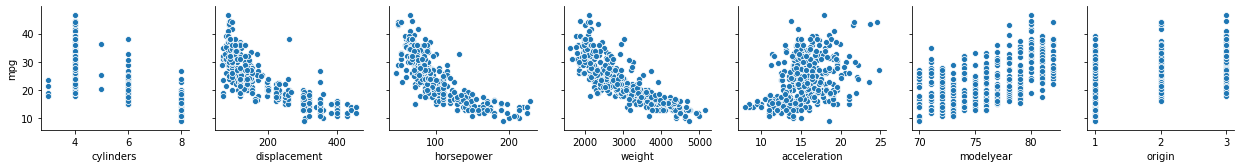

In [402]:
#sns.pairplot(df, x_vars=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'modelyear', 'origin'], y_vars= ['mpg'])

sns.pairplot(df, x_vars=df.drop(['carname','mpg'], axis=1, inplace=False).columns, y_vars= ['mpg'])

### Histogram of all other parameters except car name

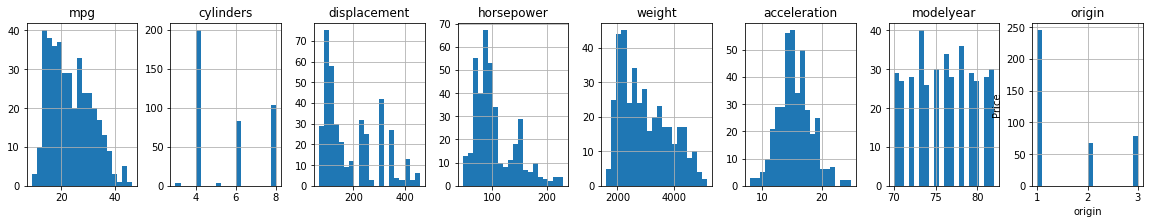

In [403]:
def histplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=20, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()
    
histplot(df, df.drop(['carname'], axis=1, inplace=False).columns)

## Set up Machine learning model

### Set up X and y

In [404]:
X = df.drop(['carname','mpg'], axis=1, inplace=False)
y = df[['mpg']]
display(X.head(3))
display(y.head(3))

,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
0,8,307.0,130.0,3504.0,12.0,70,1
1,8,350.0,165.0,3693.0,11.5,70,1
2,8,318.0,150.0,3436.0,11.0,70,1


,mpg
0,18.0
1,15.0
2,18.0


### Converting features and y to log

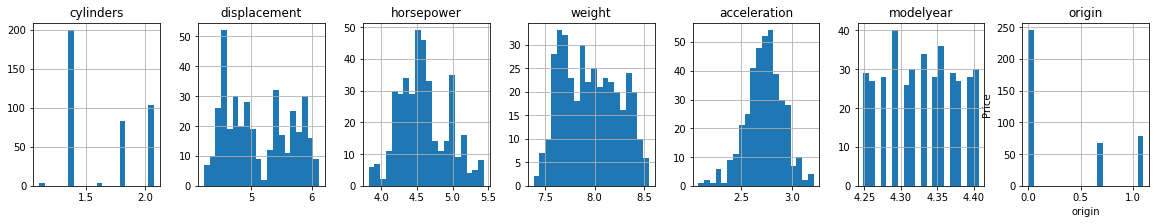

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C280B2FB70>]],
      dtype=object)

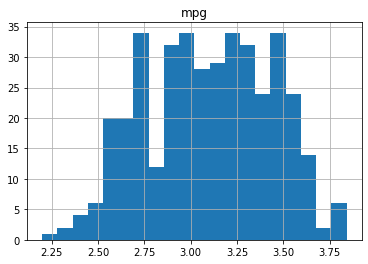

In [405]:
def convertfeatures2log(df, listvars):
    for var in listvars:
        df[var] = np.log(df[var])

convertfeatures2log(X, X.columns)
convertfeatures2log(y, y.columns)

histplot(X, X.columns)
y.hist(bins=20)

In [406]:
display(X.head(3))
display(y.head(3))

,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
0,2.079442,5.726848,4.867534,8.161660,2.484907,4.248495,0.0
1,2.079442,5.857933,5.105945,8.214194,2.442347,4.248495,0.0
2,2.079442,5.762051,5.010635,8.142063,2.397895,4.248495,0.0


,mpg
0,2.890372
1,2.708050
2,2.890372


## Test Train Split

In [407]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

display(X_train.head(2))
display(y_train.head(2))

,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
110,1.386294,4.682131,4.543295,7.774436,2.803360,4.290459,1.098612
17,1.791759,5.298317,4.442651,7.858254,2.772589,4.248495,0.000000


,mpg
110,3.091042
17,3.044522


## Run Random Forest Algo

In [408]:
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

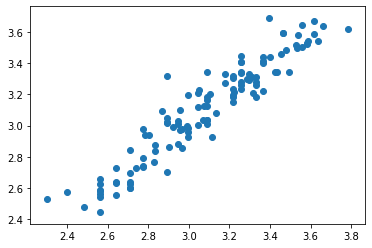

In [409]:
plt.scatter(y_test,y_pred)

In [410]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.08094627236277903
MSE: 0.011465745475267127
RMSE: 0.10707822129297408


## Select the best Machine Learning model for this regression problem 

Ignore all warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

- <b><i>cros_val_score</i></b> returns Array of scores of the estimator for each run of the cross validation
- <b><i>Kfold</i></b> splits the data into <i>n_splits</i> number of folds where for <i>n_splits</i> times, the dataset will randomly be split into train and test sets

See the following page for better explanation of cros_val_score and KFold and their use
<br> https://www.pythonforengineers.com/cross-validation-and-model-selection/


#### Testing common ML regression algos and finalising on the best based on estimator score 

In [411]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

models=[]

models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor(n_estimators=100)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR',SVR(gamma='auto')))

# now evaluate each model 
results = []
names = []
print("model: mean of score across 10 folds (std dev of score)")
for name, model in models:
    # --> split training dataset into 10 parts; train on 9 and test on 1; repeat for all combinations.
    kfold = KFold (n_splits=10, random_state=42);
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold);
    results.append(cv_results);
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.878770 (0.042622)
RF: 0.884603 (0.052844)
KNN: 0.796948 (0.092200)
CART: 0.819705 (0.063293)
SVR: 0.840068 (0.066258)


It seems the best algo is Linear Regression or Random forest

## Run backward elimination to select best features (feature selection)
- This is just an exercise but is not really needed for this project because it if most useful to reduce the number of features when there are hundreds or thousands of features.


Backward elimination -> 
- select a significance level e.g. P-score = 0.05
- fit model with all predictors (features)
- consider predictor with highest P-score. If P-score > significance level, go to step 4, else stop
- remove that predictor and fit model w/o this
- go to step 3


#### Start the first one with all predictors

In [412]:
import statsmodels.api as sm

X_train_opt = np.append(arr = np.ones((274,1)).astype(int), values = X_train, axis = 1)
X_train_opt = X_train_opt[:,[0, 1, 2, 3, 4, 5, 6, 7]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     323.0
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          4.35e-126
Time:                        16:55:01   Log-Likelihood:                 209.62
No. Observations:                 274   AIC:                            -403.2
Df Residuals:                     266   BIC:                            -374.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1020      0.807     -0.126      0.899      -1.690       1.486
x1            -0.0868      0.075     -1.160      0.247      -0.234       0.060
x2             0.0076      0.070      0.109      0.913      -0.130       0.145
x3            -0.3640      0.069     -5.293      0.000      -0.499      -0.229
x4            -0.5169      0.099     -5.235      0.000      -0.711      -0.323
x5            -0.2161      0.071     -3.061      0.002      -0.355      -0.077
x6             2.2317      0.166     13.430      0.000       1.905       2.559
x7             0.0648      0.023      2.830      0.005       0.020       0.110
==============================================================================
Omnibus:                        4.098   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                4.817
Skew:                           0.098   Prob(JB):                       0.0900
Kurtosis:                       3.619   Cond. No.                     1.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Remove the 2nd feature

In [413]:
X_train_opt = X_train_opt[:,[0, 1, 3, 4, 5, 6, 7]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     378.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          2.15e-127
Time:                        16:55:01   Log-Likelihood:                 209.61
No. Observations:                 274   AIC:                            -405.2
Df Residuals:                     267   BIC:                            -379.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1135      0.798     -0.142      0.887      -1.685       1.458
x1            -0.0809      0.052     -1.563      0.119      -0.183       0.021
x2            -0.3642      0.069     -5.308      0.000      -0.499      -0.229
x3            -0.5105      0.079     -6.453      0.000      -0.666      -0.355
x4            -0.2180      0.068     -3.197      0.002      -0.352      -0.084
x5             2.2309      0.166     13.464      0.000       1.905       2.557
x6             0.0636      0.020      3.237      0.001       0.025       0.102
==============================================================================
Omnibus:                        4.202   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.988
Skew:                           0.099   Prob(JB):                       0.0826
Kurtosis:                       3.631   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Now, remove the 1st feature too

In [414]:
X_train_opt = np.append(arr = np.ones((274,1)).astype(int), values = X_train, axis = 1)
X_train_opt = X_train_opt[:,[0,3, 4, 5, 6, 7]]
regressor_OLS = sm.O#### LS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     451.0
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          3.24e-128
Time:                        16:55:01   Log-Likelihood:                 208.37
No. Observations:                 274   AIC:                            -404.7
Df Residuals:                     268   BIC:                            -383.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.797      0.009      0.993      -1.562       1.576
x1            -0.3662      0.069     -5.324      0.000      -0.502      -0.231
x2            -0.5734      0.068     -8.394      0.000      -0.708      -0.439
x3            -0.1992      0.067     -2.960      0.003      -0.332      -0.067
x4             2.2777      0.163     13.939      0.000       1.956       2.599
x5             0.0682      0.019      3.506      0.001       0.030       0.107
==============================================================================
Omnibus:                        2.873   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                3.113
Skew:                           0.032   Prob(JB):                        0.211
Kurtosis:                       3.518   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

####  X_train vs. X_train with removed features

In [415]:
X_train.head(3)

,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
110,1.386294,4.682131,4.543295,7.774436,2.803360,4.290459,1.098612
17,1.791759,5.298317,4.442651,7.858254,2.772589,4.248495,0.000000
320,1.386294,4.779123,4.521789,7.797291,2.708050,4.382027,1.098612


In [416]:
X_train2 = X_train.iloc[:,[2,3, 4, 5, 6]]
X_train2.head(3)

X_test2 = X_test.iloc[:,[2,3, 4, 5, 6]]
X_test2.head(3)

,horsepower,weight,acceleration,modelyear,origin
79,4.234107,7.691200,2.890372,4.276666,0.693147
276,4.744932,7.935587,2.753661,4.356709,0.693147
248,4.094345,7.495542,2.797281,4.356709,1.098612


#### Now run Random forest algo on reduced number of features

In [417]:
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train2,y_train)
y_pred = rf.predict(X_test2)

In [ ]:
plt.scatter(y_test,y_pred)

#### Now calculate the MAE, MSE, RMSE - it seems the new ones are much better than ones with all features

In [420]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.07892305748619821
MSE: 0.010719451064084406
RMSE: 0.10353478190484783
